# Восстановление неполных калориметрических кластеров
Руководитель:

Алексей Болдырев

https://t.me/aboldyrev

aboldyrev@hse.ru

# Подготовка данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('https://gitlab.com/lambda-hse/lhcb-ecal-opt-public/-/raw/main/data/converted_downscope_all.csv')

In [3]:
df = df.dropna()
len(df)

70621

In [4]:
train, test = train_test_split(df, test_size=0.2, shuffle=True, random_state=0)

In [5]:
def destroy_cluster(df):
  dfs = np.array_split(df, 10)
  lst = list(range(25))
  
  for column in range(5):
    dfs[column][['l0_{}'.format(i) for i in lst[column::5]]] = np.nan
    dfs[column]['defect_loc'] = 'col_{}'.format(column)

  for row in range(5):
    dfs[row+5][['l0_{}'.format(i) for i in lst[5*row:5*row+5]]] = np.nan
    dfs[row+5]['defect_loc'] = 'row_{}'.format(row)

  df = pd.concat(dfs)
  return df

In [6]:
train = destroy_cluster(train)
test = destroy_cluster(test)

In [7]:
def show_cluster(cells_data):
  fig, ax = plt.subplots(figsize=(8,8))
  plt.imshow(cells_data, \
            norm=LogNorm(vmin=np.nanmin(cells_data)+1, vmax=np.nanmax(cells_data)))

  cbar = plt.colorbar()
  cbar.ax.tick_params(labelsize=16)

[[2.000e+00 1.200e+01       nan 5.600e+01 1.900e+01]
 [1.000e+00 3.500e+01       nan 2.790e+02 6.200e+01]
 [2.900e+01 5.010e+02       nan 8.144e+03 2.990e+02]
 [1.040e+02 1.370e+02       nan 3.010e+03 7.000e+01]
 [2.000e+00 7.200e+01       nan 3.050e+02 1.080e+02]]


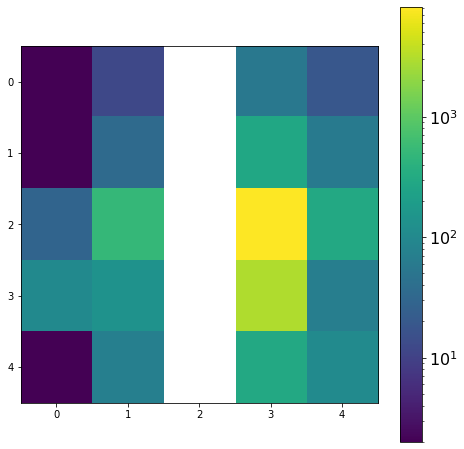

In [8]:
event = 14000
l0_cell = train[['l0_{}'.format(i) for i in range(25)]].values[event].reshape(5,5)
print(l0_cell)

show_cluster(l0_cell)

# Baseline-решение

In [9]:
from scipy import interpolate

def interpolate_missing_pixels(
        image: np.ndarray,
        mask: np.ndarray,
        method: str = 'nearest',
        fill_value: int = 0
):
    """
    :param image: a 2D image
    :param mask: a 2D boolean image, True indicates missing values
    :param method: interpolation method, one of
        'nearest', 'linear', 'cubic'.
    :param fill_value: which value to use for filling up data outside the
        convex hull of known pixel values.
        Default is 0, Has no effect for 'nearest'.
    :return: the image with missing values interpolated
    """

    h, w = image.shape[:2]
    xx, yy = np.meshgrid(np.arange(w), np.arange(h))

    known_x = xx[~mask]
    known_y = yy[~mask]
    known_v = image[~mask]
    missing_x = xx[mask]
    missing_y = yy[mask]

    interp_values = interpolate.griddata(
        (known_x, known_y), known_v, (missing_x, missing_y),
        method=method, fill_value=fill_value
    )

    interp_image = image.copy()
    interp_image[missing_y, missing_x] = interp_values

    return interp_image

[[2.0000e+00 1.2000e+01 3.4000e+01 5.6000e+01 1.9000e+01]
 [1.0000e+00 3.5000e+01 1.5700e+02 2.7900e+02 6.2000e+01]
 [2.9000e+01 5.0100e+02 4.3225e+03 8.1440e+03 2.9900e+02]
 [1.0400e+02 1.3700e+02 1.5735e+03 3.0100e+03 7.0000e+01]
 [2.0000e+00 7.2000e+01 1.8850e+02 3.0500e+02 1.0800e+02]]


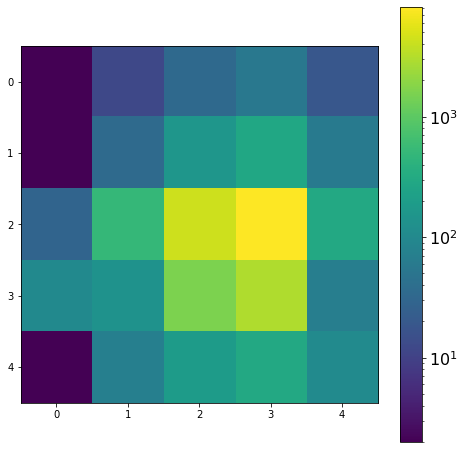

In [10]:
out = interpolate_missing_pixels(l0_cell, np.isnan(l0_cell), method='linear')
print(out)
show_cluster(out)

# Калориметрические кластеры -- не совсем обычные картинки!

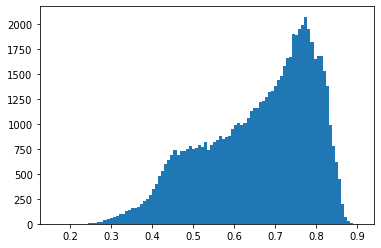

In [11]:
E_center = df.l0_12
E_all = df[['l0_{}'.format(i) for i in range(25)]].sum(axis=1)
plt.hist(E_center / E_all, bins=100);

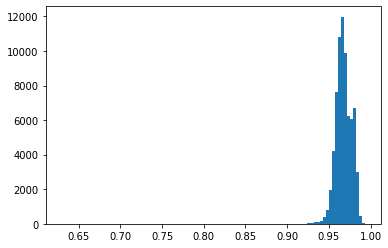

In [12]:
E_3x3 = df[['l0_{}'.format(i) for i in [6,7,8,11,12,13,16,17,18]]].values.sum(axis=1)
plt.hist(E_3x3 / E_all, bins=100);